Data 622:Final Project, Desing Neural Networks
_Pavan Akula_

The assignment is based on the online book, _Neural Networks and Deep Learning,_ by Michael Nielsen. I will be using _Minist_ dataset and two different cost functions. Data is uploaded to _Hadoop_ and processed using _Spark_. 

Initialize the _Spark_ environment. I will be reading data from Hadoop storage and populate in RDD's.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.types import *
# Import all from `sql.functions` 
from pyspark.sql.functions import *

import pandas as pd
import numpy as np
import random

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Build the SparkSession
spark = SparkSession.builder \
   .master("local") \
   .appName("Neural Network") \
   .config("spark.executor.memory", "1gb") \
   .getOrCreate()
   
sc = spark.sparkContext

Following functions will be used throughout the assignment. Functions are reproduced from online book _Neural Networks and Deep Learning_, by Michael Nielsen.

In [2]:
def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    n = int(j[0])
    e = np.zeros((10, 1))
    e[n] = 1.0
    return e

#### Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

def cost_derivative(output_activations, y):
    """Return the vector of partial derivatives \partial C_x /
    \partial a for the output activations."""
    return (output_activations-y)

def CrossEntropyCost(a, y):
    """Return the cost associated with an output ``a`` and desired output
    ``y``.  Note that np.nan_to_num is used to ensure numerical
    stability.  In particular, if both ``a`` and ``y`` have a 1.0
    in the same slot, then the expression (1-y)*np.log(1-a)
    returns nan.  The np.nan_to_num ensures that that is converted
    to the correct value (0.0).

    """
    return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))

def feedforward(a, weights, biases):
    """Return the output of the network if ``a`` is input."""
    for b, w in zip(biases, weights):
        a = sigmoid(np.dot(w, a)+b)
    return a

def evaluate(test_data, weights, biases):
    """Return the number of test inputs for which the neural
    network outputs the correct result. Note that the neural
    network's output is assumed to be the index of whichever
    neuron in the final layer has the highest activation."""
    accuracy = 0
    test_results = [(np.argmax(feedforward(x, weights, biases)), np.argmax(y))
                    for (x, y) in test_data]
    for (x, y) in test_results:
        accuracy = accuracy + int(x == y) 
    return accuracy #sum(int(x == y) for (x, y) in test_results)

Read data from Hadoop and after processing, load into a pandas data frame.

In [3]:
training_X = "hdfs:///user/pavan/final-622/data/training_X.csv"
training_Y = "hdfs:///user/pavan/final-622/data/training_Y.csv"

val_X = "hdfs:///user/pavan/final-622/data/validation_X.csv"
val_Y = "hdfs:///user/pavan/final-622/data/validation_Y.csv"

test_X = "hdfs:///user/pavan/final-622/data/test_X.csv"
test_Y = "hdfs:///user/pavan/final-622/data/test_Y.csv"

rdd_trX = sc.textFile(training_X)
rdd_trY = sc.textFile(training_Y)

rdd_ttX = sc.textFile(test_X)
rdd_ttY = sc.textFile(test_Y)

rdd_valX = sc.textFile(val_X)
rdd_valY = sc.textFile(val_Y)

rdd_trX = rdd_trX.map(lambda line: line.split(","))
rdd_trY = rdd_trY.map(lambda line: line.split(","))

rdd_ttX = rdd_ttX.map(lambda line: line.split(","))
rdd_ttY = rdd_ttY.map(lambda line: line.split(","))

rdd_valX = rdd_valX.map(lambda line: line.split(","))
rdd_valY = rdd_valY.map(lambda line: line.split(","))

Df_trX = rdd_trX.toDF()
for i in range(784):
    name = '_' + str(i+1)
    Df_trX = Df_trX.withColumn(name, Df_trX[name].cast(FloatType()))
    
Df_ttX = rdd_ttX.toDF()
for i in range(784):
    name = '_' + str(i+1)
    Df_ttX = Df_ttX.withColumn(name, Df_ttX[name].cast(FloatType()))
    
Df_valX = rdd_valX.toDF()
for i in range(784):
    name = '_' + str(i+1)
    Df_valX = Df_valX.withColumn(name, Df_valX[name].cast(FloatType()))

training_inputs = [np.reshape(x, (784, 1)) for x in Df_trX.rdd.collect()]
test_inputs = [np.reshape(x, (784, 1)) for x in Df_ttX.rdd.collect()]
validation_inputs = [np.reshape(x, (784, 1)) for x in Df_valX.rdd.collect()]

# Map the RDD to a DF training dataset
Df_trY = rdd_trY.toDF()
Df_trY = Df_trY.withColumn('_1', Df_trY['_1'].cast(FloatType()))
training_results = [vectorized_result(y) for y in Df_trY.rdd.collect()]
training_data = zip(training_inputs, training_results)

# Map the RDD to a DF test dataset
Df_ttY = rdd_ttY.toDF()
Df_ttY = Df_ttY.withColumn('_1', Df_ttY['_1'].cast(FloatType()))
test_results = [vectorized_result(y) for y in Df_ttY.rdd.collect()]
test_data = zip(test_inputs, test_results)

# Map the RDD to a DF validation dataset
Df_valY = rdd_valY.toDF()
Df_valY = Df_valY.withColumn('_1', Df_valY['_1'].cast(FloatType()))
validation_results = [vectorized_result(y) for y in Df_valY.rdd.collect()]
validation_data = zip(validation_inputs, validation_results)

#Convert datasets into lists
training_data = list(training_data)
n = len(training_data)
test_data = list(test_data)
n_test = len(test_data)
validation_data = list(validation_data)
n_val = len(validation_data)

random.shuffle(training_data)

Displayed are top 20 images from training dataset.

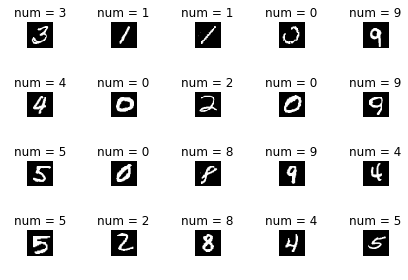

In [4]:
i = 0
for x,y in training_data:
    image = x.reshape(28, 28)
    plt.subplot(4, 5, i+1)
    plt.imshow(image, cmap='gray')
    plt.title('num = {}'.format(np.argmax(y)))
    plt.axis('off')  
    i = i + 1
    if i==20:
        break
    
plt.tight_layout()
plt.show()

For the scope of the assignment, I have two hidden layers with 36 neurons. Input dataset has 784 independent variables(_x_). The model contains a total of four layers, 

- Input layer, 784 _x_ variables
- Hidden layer, 36 neurons, neuron contains data that is derived using the summation of the dot product between _x_ and weights, plus biases.
- Output layer, it is vectorized output of numeric values of dependent variable _y_. The vector contains 10 valid outputs.

In simple terms, we could conclude that we are using neural networks to solve the classification problem. As out is classified into 0-9 numbers.

Let's activate hidden layers and predict output layer using training data.

In [5]:
#Initiate layers
sizes = [784, 36, 36, 10]

#Assign random weights, seed it so results could be reproduced
np.random.seed(2003)
num_layers = len(sizes)
biases = [np.random.randn(y, 1) for y in sizes[1:]]
weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

#Activations, using sigmoid function
activations = []

#loop through each observations and calculate sigmoid
for x, y in training_data:
    activations.append(x)
    activation = x
    
    # This loop will convert 784 observation to first hidden layer 36 neurons and then second hiidden layer
    # ultimately generates 10 valid outputs
    for w, b in zip(weights, biases):
        z = np.dot(w, activation)+b
        activation = sigmoid(z)
        activations.append(activation)


After running activations on all the observations, follows displays how the model learns the data.

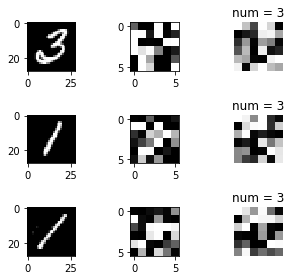

In [6]:
i = 0
for i in range(0, len(activations), 4):
    image1 = activations[i].reshape(28, 28)
    image2 = activations[i+1].reshape(6, 6)
    image3 = activations[i+2].reshape(6, 6)
    #image4 = activations[i+3] #.reshape(28, 28)
    plt.subplot(3, 4, i+1)
    plt.imshow(image1, cmap='gray')
    plt.subplot(3, 4, i+2)
    plt.imshow(image2, cmap='gray')
    plt.subplot(3, 4, i+3)
    plt.imshow(image3, cmap='gray')
    #plt.imshow(image4, cmap='gray')
    plt.title('num = {}'.format(np.argmax(activations[i+3])))
    plt.axis('off')  
    i = i + 1
    if i>8:
        break
plt.tight_layout()
plt.show()


The accuracy of the model after running once is 8%. The model predicts 4041 observations correctly out of 50000 observations. This indicates model performs very poorly. This method is also called _feed forward_.

In [7]:
i = 3
accuracy = 0
accuracy_id = []
for x, y in training_data:
    predit = np.argmax(activations[i])
    actual = np.argmax(y)
    accuracy = accuracy + int(predit == actual)
    if int(predit == actual)>0:
        accuracy_id.append(i)
    i = i + 4
    

In [8]:
print(accuracy)

4041


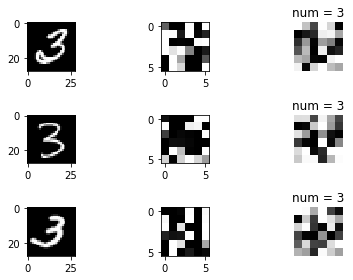

In [9]:
j = 0
for i in accuracy_id[:3]:
    image1 = activations[i-3].reshape(28, 28)
    image2 = activations[i-2].reshape(6, 6)
    image3 = activations[i-1].reshape(6, 6)
    #image4 = activations[i+3] #.reshape(28, 28)
    plt.subplot(3, 3, j+1)
    plt.imshow(image1, cmap='gray')
    plt.subplot(3, 3, j+2)
    plt.imshow(image2, cmap='gray')
    plt.subplot(3, 3, j+3)
    plt.imshow(image3, cmap='gray')
    #plt.imshow(image4, cmap='gray')
    plt.title('num = {}'.format(np.argmax(activations[i])))
    plt.axis('off')  
    j = j + 3

plt.tight_layout()
plt.show()

Let's apply _back propagation_ and fix weights and biases to improve the prediction. During this process, we will be using hyper-parameters

- epoch, one epoch is when entire dataset is passed forward and backward through the neural network once. For the scope of the assignment, I have used 30. In other words, full dataset is processed 30 times to improve the weights and biases.
- mini_batch_size, since the dataset is large and takes a lot of resources for processing, I have split the dataset into a batch of 10 observations and a total of 5000 batches.
- eta, learning rate. It is greek alphabet Eta, $\eta\$, this is picked randomly.

In the following example, I am using eta as 1.

In [10]:
eta = 1
epochs = 30
mini_batch_size = 10


for j in range(epochs):
    #After each forward and backword passes re-shuffle entire dataset.
    random.shuffle(training_data)
    mini_batches = [
        training_data[k:k+mini_batch_size]
        for k in range(0, n, mini_batch_size)]

    for mini_batch in mini_batches:
        #Activate hidden layers for each observation
        for x, y in mini_batch:
            activations = []
            activations.append(x)
            activation = x
            zs = []
            delta = [np.zeros(b.shape) for b in biases]
            nweight = [np.zeros(w.shape) for w in weights]
            #Feed Forward
            for w, b in zip(weights, biases):
                z = np.dot(w, activation)+b
                zs.append(z)
                activation = sigmoid(z)
                activations.append(activation)
            #Backward Propogation
            for l in range(1, num_layers):
                if l==1:
                    delta[-l] = cost_derivative(activations[-l], y) * sigmoid_prime(zs[-l])
                    nweight[-l] = np.dot(delta[-l], activations[-l-1].transpose())
                else:
                    delta[-l] = np.dot(weights[-l+1].transpose(), delta[-l+1]) * sigmoid_prime(zs[-l])
                    nweight[-l] = np.dot(delta[-l], activations[-l-1].transpose())
         
            weights = [w-(eta/len(mini_batch))*nw for w, nw in zip(weights, nweight)]
            biases = [b-(eta/len(mini_batch))*nb for b, nb in zip(biases, delta)]

    print("Epoch {0}: {1} / {2}".format(j, evaluate(test_data, weights, biases), n_test))


Epoch 0: 8826 / 10000
Epoch 1: 9080 / 10000
Epoch 2: 9186 / 10000
Epoch 3: 9232 / 10000
Epoch 4: 9300 / 10000
Epoch 5: 9328 / 10000
Epoch 6: 9373 / 10000
Epoch 7: 9356 / 10000
Epoch 8: 9405 / 10000
Epoch 9: 9396 / 10000
Epoch 10: 9426 / 10000
Epoch 11: 9426 / 10000
Epoch 12: 9416 / 10000
Epoch 13: 9412 / 10000
Epoch 14: 9445 / 10000
Epoch 15: 9410 / 10000
Epoch 16: 9434 / 10000
Epoch 17: 9449 / 10000
Epoch 18: 9465 / 10000
Epoch 19: 9460 / 10000
Epoch 20: 9467 / 10000
Epoch 21: 9476 / 10000
Epoch 22: 9484 / 10000
Epoch 23: 9489 / 10000
Epoch 24: 9478 / 10000
Epoch 25: 9482 / 10000
Epoch 26: 9477 / 10000
Epoch 27: 9470 / 10000
Epoch 28: 9466 / 10000
Epoch 29: 9491 / 10000


Following example uses eta as 2.

In [11]:
#Assign random weights, seed it so results could be reproduced
np.random.seed(2003)
num_layers = len(sizes)
biases = [np.random.randn(y, 1) for y in sizes[1:]]
weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

eta = 2
epochs = 30
mini_batch_size = 10


for j in range(epochs):
    #After each forward and backword passes re-shuffle entire dataset.
    random.shuffle(training_data)
    mini_batches = [
        training_data[k:k+mini_batch_size]
        for k in range(0, n, mini_batch_size)]

    for mini_batch in mini_batches:
        #Activate hidden layers for each observation
        for x, y in mini_batch:
            activations = []
            activations.append(x)
            activation = x
            zs = []
            delta = [np.zeros(b.shape) for b in biases]
            nweight = [np.zeros(w.shape) for w in weights]
            #Feed Forward
            for w, b in zip(weights, biases):
                z = np.dot(w, activation)+b
                zs.append(z)
                activation = sigmoid(z)
                activations.append(activation)
            #Backward Propogation
            for l in range(1, num_layers):
                if l==1:
                    delta[-l] = cost_derivative(activations[-l], y) * sigmoid_prime(zs[-l])
                    nweight[-l] = np.dot(delta[-l], activations[-l-1].transpose())
                else:
                    delta[-l] = np.dot(weights[-l+1].transpose(), delta[-l+1]) * sigmoid_prime(zs[-l])
                    nweight[-l] = np.dot(delta[-l], activations[-l-1].transpose())
         
            weights = [w-(eta/len(mini_batch))*nw for w, nw in zip(weights, nweight)]
            biases = [b-(eta/len(mini_batch))*nb for b, nb in zip(biases, delta)]

    print("Epoch {0}: {1} / {2}".format(j, evaluate(test_data, weights, biases), n_test))

Epoch 0: 9115 / 10000
Epoch 1: 9178 / 10000
Epoch 2: 9329 / 10000
Epoch 3: 9341 / 10000
Epoch 4: 9369 / 10000
Epoch 5: 9392 / 10000
Epoch 6: 9402 / 10000
Epoch 7: 9472 / 10000
Epoch 8: 9470 / 10000
Epoch 9: 9455 / 10000
Epoch 10: 9458 / 10000
Epoch 11: 9453 / 10000
Epoch 12: 9483 / 10000
Epoch 13: 9497 / 10000
Epoch 14: 9501 / 10000
Epoch 15: 9506 / 10000
Epoch 16: 9505 / 10000
Epoch 17: 9504 / 10000
Epoch 18: 9496 / 10000
Epoch 19: 9520 / 10000
Epoch 20: 9481 / 10000
Epoch 21: 9520 / 10000
Epoch 22: 9528 / 10000
Epoch 23: 9507 / 10000
Epoch 24: 9503 / 10000
Epoch 25: 9527 / 10000
Epoch 26: 9527 / 10000
Epoch 27: 9523 / 10000
Epoch 28: 9523 / 10000
Epoch 29: 9514 / 10000


Comparing the results with _eta_ as 1 and eta as 2, later model learns at a faster rate. _eta_ is one of the hyper-parameter that can be tuned to make learning faster. On larger datasets tuning _eta_ is a time-consuming process.

To speed up the process, we could change the complete cost evaluation method and use a new technique called _cross-entropy_. This method uses hyper-parameter known as lambda, $\lambda$ to make learning fast.

In [14]:
#Assign random weights, seed it so results could be reproduced
np.random.seed(2003)
num_layers = len(sizes)
biases = [np.random.randn(y, 1) for y in sizes[1:]]
weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

eta = 1
epochs = 30
mini_batch_size = 10
lmbda = 5.0

for j in range(epochs):
    #After each forward and backword passes re-shuffle entire dataset.
    random.shuffle(training_data)
    mini_batches = [
        training_data[k:k+mini_batch_size]
        for k in range(0, n, mini_batch_size)]

    for mini_batch in mini_batches:
        #Activate hidden layers for each observation
        for x, y in mini_batch:
            activations = []
            activations.append(x)
            activation = x
            zs = []
            delta = [np.zeros(b.shape) for b in biases]
            nweight = [np.zeros(w.shape) for w in weights]
            #Feed Forward
            for w, b in zip(weights, biases):
                z = np.dot(w, activation)+b
                zs.append(z)
                activation = sigmoid(z)
                activations.append(activation)
            #Backward Propogation
            for l in range(1, num_layers):
                if l==1:
                    delta[-l] = cost_derivative(activations[-l], y)
                    nweight[-l] = np.dot(delta[-l], activations[-l-1].transpose())
                else:
                    delta[-l] = np.dot(weights[-l+1].transpose(), delta[-l+1]) * sigmoid_prime(zs[-l])
                    nweight[-l] = np.dot(delta[-l], activations[-l-1].transpose())
        
            #Calculate weights using cross-entropy
            weights = [(1-eta*(lmbda/n))*w-(eta/len(mini_batch))*nw for w, nw in zip(weights, nweight)]
            biases = [b-(eta/len(mini_batch))*nb for b, nb in zip(biases, delta)]


    print("Epoch {0}: {1} / {2}".format(j, evaluate(test_data, weights, biases), n_test))

Epoch 0: 9150 / 10000
Epoch 1: 9141 / 10000
Epoch 2: 9235 / 10000
Epoch 3: 9041 / 10000
Epoch 4: 9243 / 10000
Epoch 5: 8909 / 10000
Epoch 6: 9213 / 10000
Epoch 7: 8989 / 10000
Epoch 8: 9305 / 10000
Epoch 9: 9094 / 10000
Epoch 10: 9260 / 10000
Epoch 11: 9273 / 10000
Epoch 12: 9053 / 10000
Epoch 13: 9121 / 10000
Epoch 14: 9298 / 10000
Epoch 15: 9054 / 10000
Epoch 16: 9257 / 10000
Epoch 17: 9307 / 10000
Epoch 18: 9307 / 10000
Epoch 19: 9136 / 10000
Epoch 20: 9321 / 10000
Epoch 21: 9317 / 10000
Epoch 22: 9223 / 10000
Epoch 23: 9232 / 10000
Epoch 24: 9276 / 10000
Epoch 25: 9298 / 10000
Epoch 26: 9348 / 10000
Epoch 27: 9055 / 10000
Epoch 28: 9141 / 10000
Epoch 29: 9309 / 10000


####Referances

- http://neuralnetworksanddeeplearning.com/index.html
- http://blog.madhukaraphatak.com/spark-vector-to-numpy/
- https://www.analyticsvidhya.com/blog/2016/10/spark-dataframe-and-operations/
- https://github.com/MichalDanielDobrzanski/DeepLearningPython35